# Jupyter Notebook for Data Preprocessing

### Importing Required Libraries

In [8]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import logging
import re
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.cuda.amp import autocast
import torch
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Load Original Dataset

In [9]:
# Load original intent data from JSON file
with open ("data/intents_original.json") as file:
    data = json.load(file)

# Create DataFrame from JSON data
df = pd.DataFrame(data['intents'])
df

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."
...,...,...,...
75,fact-28,[What do I do if I'm worried about my mental h...,[The most important thing is to talk to someon...
76,fact-29,[How do I know if I'm unwell?],"[If your beliefs , thoughts , feelings or beha..."
77,fact-30,[How can I maintain social connections? What i...,"[A lot of people are alone right now, but we d..."
78,fact-31,[What's the difference between anxiety and str...,[Stress and anxiety are often used interchange...


### Preparing Data For Augmentation

In [10]:
# Initialize an empty dictionary to store tags, patterns, and responses
dic = {"tag":[], "patterns":[], "responses":[]}

# Extract patterns, responses, and tags for further augmentation
for i in range(len(df)):
    ptrns = df[df.index == i]['patterns'].values[0]
    rspns = df[df.index == i]['responses'].values[0]
    tag = df[df.index == i]['tag'].values[0]
    for j in range(len(ptrns)):
        dic['tag'].append(tag)
        dic['patterns'].append(ptrns[j])
        dic['responses'].append(rspns)

In [11]:
# Convert the dictionary into a pandas DataFrame
df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [12]:
df['tag'].nunique()

80

In [13]:
df['tag'].value_counts()

tag
greeting    12
casual      11
goodbye      8
default      8
about        8
            ..
fact-10      1
fact-11      1
fact-12      1
fact-13      1
fact-8       1
Name: count, Length: 80, dtype: int64

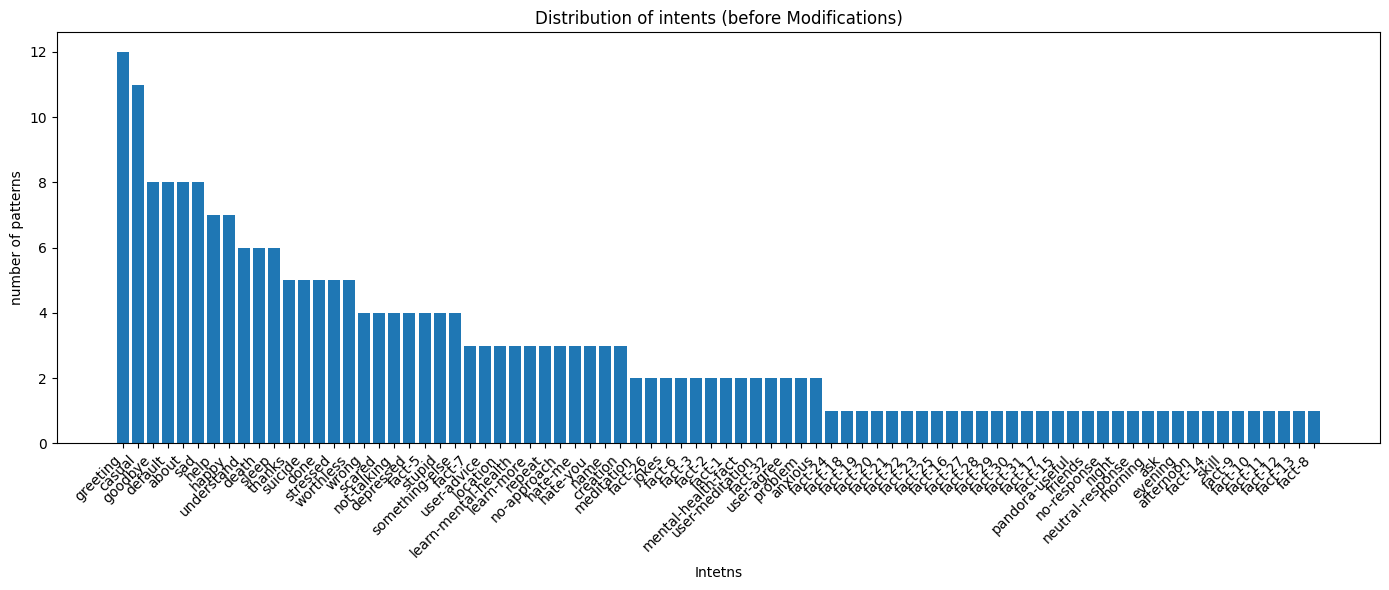

In [14]:
plt.figure(figsize=(14,6))

plt.bar(df['tag'].value_counts().index,df['tag'].value_counts().values)

plt.title('Distribution of intents (before Modifications)')
plt.xlabel('Intetns')
plt.ylabel('number of patterns')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Graph shows pattern distribution per intent pre augmentation.

### Paraphrasing Augmentation

In [15]:
# Initialize the model and tokenizer
model_name = "tuner007/pegasus_paraphrase"
device = "cpu"
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
tokenizer = PegasusTokenizer.from_pretrained(model_name)

# Enable logging
logging.basicConfig(level=logging.INFO)

def paraphrase_with_pegasus(text, num_return_sequences=3, num_beams=10):
    """ Generate multiple paraphrases from Pegasus model. """
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with autocast():
        outputs = model.generate(
            input_ids["input_ids"],
            attention_mask=input_ids["attention_mask"],
            max_length=80,
            num_beams=num_beams,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            early_stopping=True
        )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)  # Return multiple paraphrases

def is_valid_pattern(new_pattern, unique_patterns):
    """ Check if the new pattern is valid (not just case or punctuation change). """
    new_pattern_normalized = re.sub(r'[^\w\s]', '', new_pattern.lower())
    for pattern in unique_patterns:
        pattern_normalized = re.sub(r'[^\w\s]', '', pattern.lower())
        if new_pattern_normalized == pattern_normalized:
            return False
    return True

def augment_patterns(tags_patterns, target_count=30):
    """ Generate paraphrases efficiently until each tag has at least 12 unique patterns. """
    augmented_patterns = {}

    for tag, patterns in tags_patterns.items():
        logging.info(f"Starting augmentation for tag: {tag}")

        # Create a set of unique patterns
        unique_patterns = set(patterns)
        pattern_queue = list(unique_patterns)  

        # Keep generating paraphrases until the target count is reached
        while len(unique_patterns) < target_count:
            if not pattern_queue:
                break  # No more patterns to process
            
            current_pattern = pattern_queue.pop(0)  # Get next pattern
            
            # Generate multiple new patterns at once
            new_patterns = paraphrase_with_pegasus(current_pattern, num_return_sequences=3)

            for new_pattern in new_patterns:
                new_pattern = new_pattern.strip().lower()

                if len(unique_patterns) >= target_count:
                    break  # Stop if we already reached target patterns

                # Validate the new pattern before adding
                if is_valid_pattern(new_pattern, unique_patterns):
                    unique_patterns.add(new_pattern)
                    pattern_queue.append(new_pattern)  # Add new pattern for further paraphrasing

            logging.info(f"Tag: {tag} | Unique patterns: {len(unique_patterns)}/{target_count}")

        augmented_patterns[tag] = list(unique_patterns)[:target_count]  # Ensure exactly target count

        logging.info(f"Completed augmentation for tag: {tag} | Total patterns: {len(unique_patterns)}")

    return augmented_patterns


# Load the original JSON data
with open('data/intents_original.json', 'r') as f:
    original_data = json.load(f)

# Extract tags and patterns
tags_patterns = {intent['tag']: intent['patterns'] for intent in original_data['intents']}

# Augment patterns
augmented_patterns = augment_patterns(tags_patterns)

# Update the original data with augmented patterns
for intent in original_data['intents']:
    tag = intent['tag']
    if tag in augmented_patterns:
        intent['patterns'] = augmented_patterns[tag]

# Save the updated data back to the JSON file
with open('data/intents_augmented.json', 'w') as f:
    json.dump(original_data, f, indent=4)

logging.info("Augmentation completed and data saved to 'intents_augmented.json'")


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Starting augmentation for tag: greeting
C:\Users\Jamie\AppData\Local\Temp\ipykernel_10884\3158899282.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\Jamie\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
INFO:root:Tag: greeting | Unique patterns: 13/30
INFO:root:Tag: greeting | Unique patterns: 14/30
INFO:root:Tag: greeting | Unique patterns: 15/30
INFO:root:Tag: greeting | Unique patter

### Data Processing after Augmentation

In [16]:
# Load the augmented intent data
with open("data/intents_augmented.json") as f:
    data2 = json.load(f)

# Initialize an empty dictionary to store tags, patterns, and responses
dic2  = {"tag":[] ,"patterns":[], "responses":[]}

# Iterate through the intents and their patterns to populate the dictionary
for example in data2['intents']:
    for pattern in example["patterns"]:
        dic2["patterns"].append(pattern)
        dic2["tag"].append(example["tag"])
        dic2["responses"].append(example["responses"])

# Convert the dictionary into a pandas DataFrame
df2 = pd.DataFrame.from_dict(dic2)

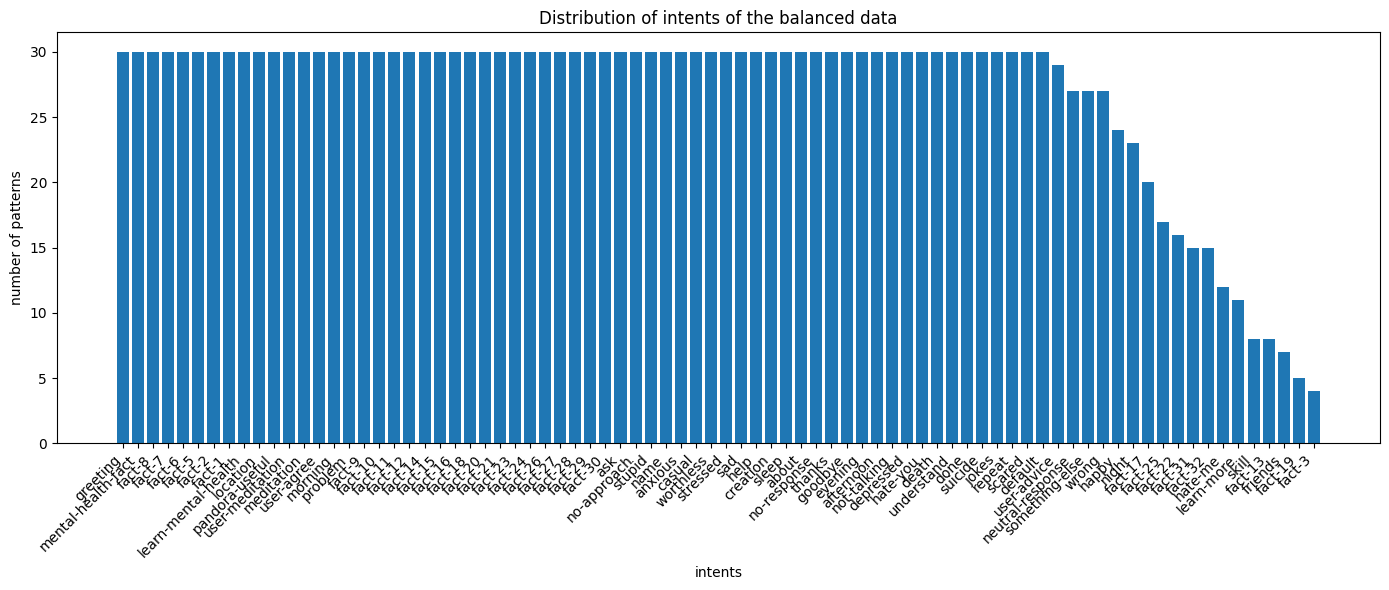

In [17]:
plt.figure(figsize=(14,6))

plt.bar(df2['tag'].value_counts().index,df2['tag'].value_counts().values)

plt.title('Distribution of intents of the balanced data')
plt.xlabel("intents")
plt.ylabel("number of patterns")

plt.xticks(rotation = 45  , ha = "right")
plt.tight_layout()

plt.show()

Graph shows pattern distrubution per intent post augmentation.

### Duplication Deletion

In [18]:
df2['patterns'].duplicated().sum()

112

In [19]:
df2[df2['patterns'].duplicated()]

,tag,patterns,responses
60,afternoon,it was nice to start.,[Good afternoon. How is your day going?]
64,afternoon,a great start to the day.,[Good afternoon. How is your day going?]
69,afternoon,it was good to start the day.,[Good afternoon. How is your day going?]
70,afternoon,good start to the day.,[Good afternoon. How is your day going?]
73,afternoon,a good start to the day.,[Good afternoon. How is your day going?]
...,...,...,...
1880,fact-21,where can i get help?,[Different kinds of therapy are more effective...
1975,fact-26,mental health problems can be solved.,[It is often more realistic and helpful to fin...
1986,fact-26,mental health issues can be solved.,[It is often more realistic and helpful to fin...
1997,fact-26,mental health issues can be fixed.,[It is often more realistic and helpful to fin...


In [20]:
df2.drop_duplicates(subset=['patterns'],inplace=True)

In [21]:
df2['patterns'].duplicated().sum()

0

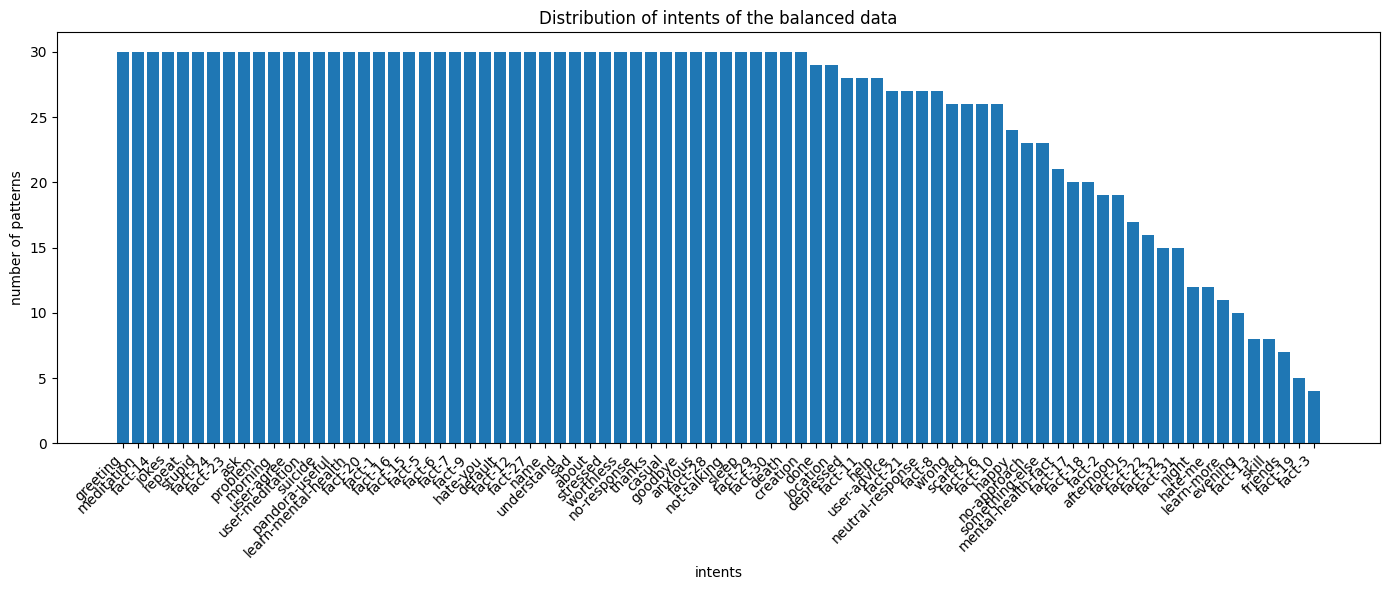

In [22]:
plt.figure(figsize=(14,6))

plt.bar(df2['tag'].value_counts().index,df2['tag'].value_counts().values)

plt.title('Distribution of intents of the balanced data')
plt.xlabel("intents")
plt.ylabel("number of patterns")

plt.xticks(rotation = 45  , ha = "right")
plt.tight_layout()

plt.show()

Graph shows pattern distribution per intent post augmentation and duplication deletion.

### Conversion to JSON and Saving

In [23]:
# Convert the DataFrame to a list of records (dictionaries)
cleaned_data = df2.to_dict(orient="records")

# Group intents by their tags
grouped_intents = {}

# Iterate through the records and group them by their tag
for intent in cleaned_data:
    tag = intent["tag"]
    pattern = intent["patterns"]
    response = intent["responses"]

    # If the tag exists, append the pattern, else create a new entry for the tag
    if tag in grouped_intents:
        grouped_intents[tag]["patterns"].append(pattern)
    else:
        grouped_intents[tag] = {
            "tag": tag,
            "patterns": [pattern],
            "responses": response  # Responses are assumed to be the same for all patterns of the tag
        }

# Convert the grouped intents into the final structure
final_intents = {"intents": list(grouped_intents.values())}

# Save the grouped and cleaned data to a JSON file in one go
with open("data/intents_final.json", "w", encoding="utf-8") as file:
    json.dump(final_intents, file, indent=4, ensure_ascii=False)
